# Free Code Camp SEOUL BIKE Dataset Lesson
# Mariah Noelle Cornelio
### Video Used: https://youtu.be/i_LwzRVP7bg?si=q0RcxMpMv5_mnBpN

## Moving on from classification to regression

### Regression
- Other type of supervised learning other than classification
- Our goal in regression is to find line of best fit that best models the data
- Asks: if I have an x-value, what is my predicted y-value?
- Formula
    - Simple linear regression
        - y = b0 + b1x
    - Multiple linear regression
        - y = b0 + b1x1 + b2x2 + . . . + bnxn
    
### Residual (Error)
- How far off is the prediction to the actual data point we already have
- y hat
- Formula
    - | yi - yi hat | 
    - Absolute value because what if the point is below the line
- Sum of squared residuals
    - Adds higher penalty of how far off we are
    
### Line of best fit
- Tries to decrease the error as much as possible for all data points
    - Minimizing the sum of all residuals/error
    
### Assumptions
- Linearity
    - Does data follow a linear patter (x inc/dec as y inc/dec at a constant rate)
    - Parabola is non-linear or x^3 function or a curve
- Independence
    - Points do not have influence on other points
    - All samples are independent
- Normality
    - Use residuals ( y - y hat ) and plots it -> residual plot
    - Residuals should be normally distributed around line of best fit
- Homoskedasticity
    - Use residuals ( y - y hat ) and plots it -> residual plot
    - Variances of these points should stay constant (spread at one place is the same as the spread in another place)
    - Does not help if spread is not constant (decreases or something) 
        - In this case, it is not wise to use linear regression
        
### How to evaluate a linear regression model
#### 1) Mean Absolute Error (MAE)
- Take all residuals, sum up distance for all of them, and then take average to see how far off you are
- MAE = sum of all | yi - yi hat | / n 
    - n is the number of data points
- In house pricing example, this is saying "how many dollars are we off by" 

#### 2) Mean Squared Error (MSE)
- MSE = sum of all (yi - yi hat)^2 / n
    - Instead of absolute value, you swuare them
    - Square them first before adding them to each other
- This helps us punish large errors in the prediction
- Helps in differentiability (quadratic equation)
- Cannot compare MSE to actual y value because it is now squared

#### 3) Root Mean Squared Error
- Square root of MSE
- Now it is in terms of dollars instead of dollars squared (same unit)

#### 4) Coefficient of Determination (R^2)
- 1 - (RSS/TSS)
    - RSS = sum of squared residuals
        - Sum of all ( yi - yi hat )^2
        - What is our error in respect to line of best fit
        - If this is better, then RSS is smaller than TSS (makes a small ratio)
    - TSS = total sum of squares
        - Sum of all ( yi - mean of y )^2
        - The further the data points are, the larger the TSS is going to be
        - What is our error in respect to the average y value
- With respect to that average, what is our error? 
- If R^2 = 1 or close to 1, it means we have a good predictor :)
- There is also an adjusted R^2 that adjusts how many x terms we have
    - Usually if we add an x term, the R^2 will increase to help predicted y more
    - This value says does the new term improve the model

## Importing and preprocessing data

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [118]:
dataset_cols=["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp",
             "radiation", "rain", "snow", "functional"]
# Open up csv first to get rid of forbidden labels so we can properly import data
df=pd.read_csv("SeoulBikeData.csv")
df.head()

,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,1/12/17,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1/12/17,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,1/12/17,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,1/12/17,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,1/12/17,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [119]:
# Drop columns we don't care about, axis=1 means drop from columns

df=pd.read_csv("SeoulBikeData.csv").drop(["Date", "Holiday", "Seasons"], axis=1)
# Rename the columns so it is easier to read
df.columns=dataset_cols
# Convert functional column to 0 and 1's because computers are better at reading numbers
df["functional"]=(df["functional"]=="Yes").astype(int)
# Index on an hour (noon) and then drop the column - all the data poitns are for bikes at noon
df=df[df["hour"]==12]
df=df.drop(["hour"], axis=1)
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


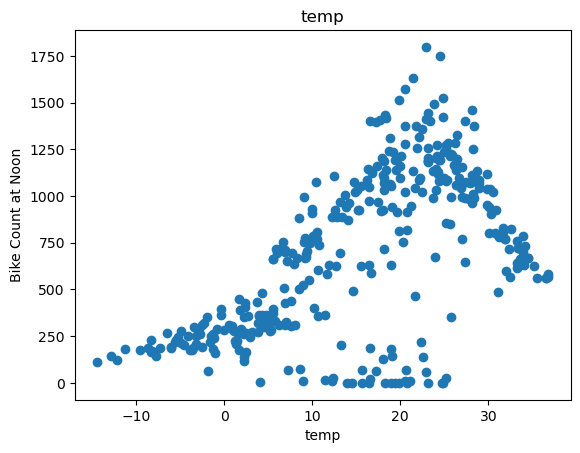

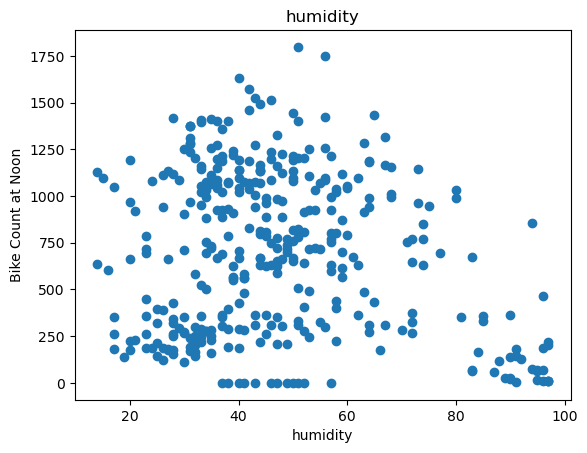

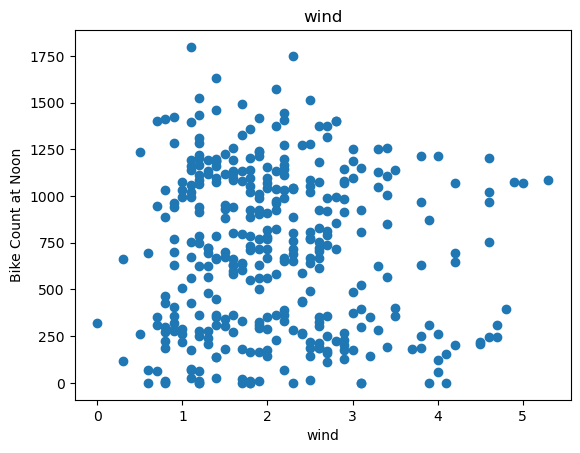

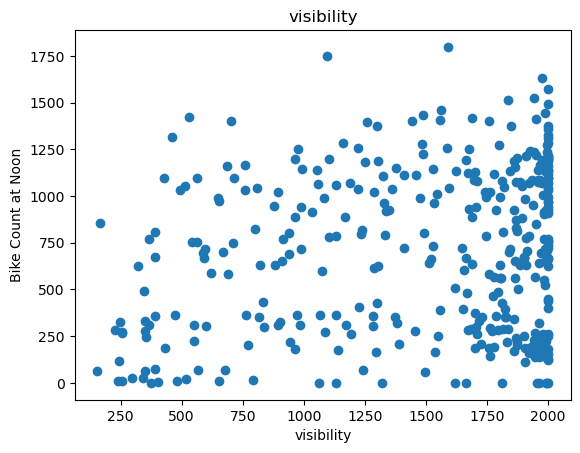

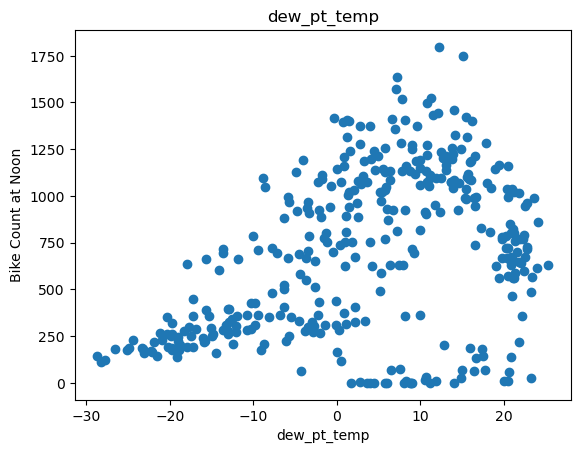

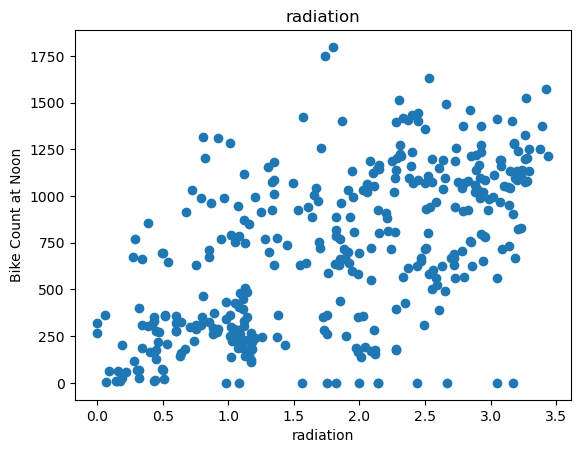

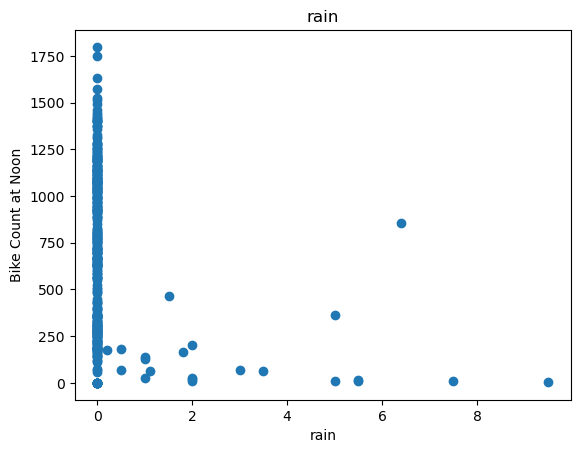

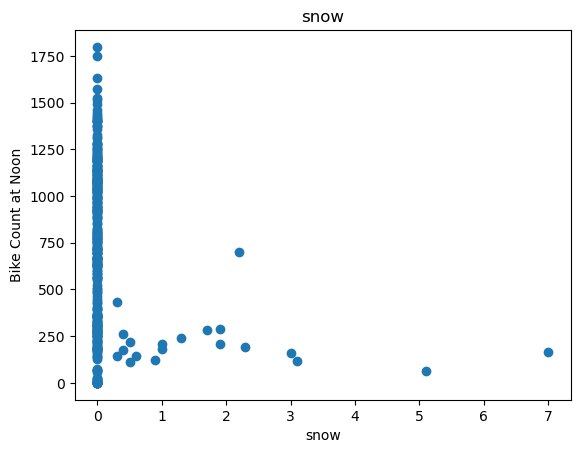

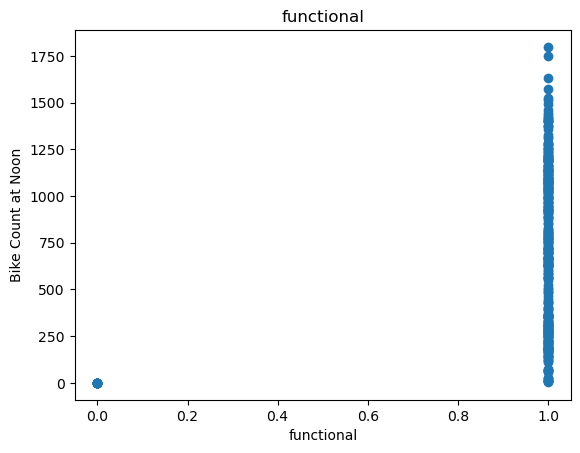

In [120]:
# Visualize the data first
for label in df.columns[1:]: # Everything after the first thing (features)
    plt.scatter(df[label], df["bike_count"]) # See how features affect bike count
    plt.title(label)
    plt.ylabel("Bike Count at Noon")
    plt.xlabel(label)
    plt.show()

In [121]:
# There seems to be a relationship between temperature and bike count
# Drop the columns that don't seem like they matter
df=df.drop(["wind", "visibility", "functional"], axis=1)
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


## Create training, validation, and test datasets

In [122]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [123]:
def get_xy(dataframe, y_label, x_labels=None):
    dataframe=copy.deepcopy(dataframe) # Copying everything over
    if x_labels is None:
        X=dataframe[[c for c in dataframe.columns if c!=y_label]].values
    else:
        if len(x_labels)==1:
            X=dataframe[x_labels[0]].values.reshape(-1,1)
        else:
            X=dataframe[x_labels].values
            
    y=dataframe[y_label].values.reshape(-1,1)
    data=np.hstack((X,y))
    
    return data,X,y

## Simple Linear Regression

In [124]:
# Sets for just temperature to show simple linear regression

_, X_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])
_, X_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels=["temp"])
_, X_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])

In [125]:
temp_reg= LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [126]:
print(temp_reg.coef_, temp_reg.intercept_)
# Coefficient for temperature, then y intercet

[[20.23409381]] [371.05105047]


In [127]:
# This is the R^2 value - not good association
temp_reg.score(X_test_temp, y_test_temp)

0.2797821576585823

<function matplotlib.pyplot.show(close=None, block=None)>

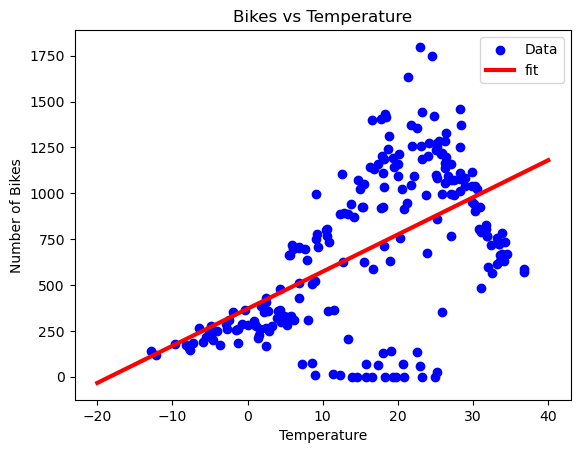

In [128]:
# Plot it

plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x=tf.linspace(-20, 40, 100) # Takes 100 things 
# Make x into array and then reshape it to make it 2D or else there will be an error telling you to do so
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1,1)), label="fit", color="red", linewidth=3) # Line width changes how thick value is
plt.legend()
plt.title("Bikes vs Temperature")
plt.ylabel("Number of Bikes")
plt.xlabel("Temperature")
plt.show

## Multiple Linear Regression

In [129]:
_, X_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, "bike_count", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])

In [130]:
all_reg=LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [131]:
# Improves to 0.5
all_reg.score(X_test_all, y_test_all)

0.44639921155471085

## Regression with Neural Network
### This example is with simple linear regression using the temperature column but you can also do it as multiple linear regression

In [132]:
# For linear regression models, it helps if data is normalized
def plot_loss(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    plt.show()
    
temp_normalizer=tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1)) # Reduces to single vector

/Users/marielle/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [133]:
temp_nn_model=tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1) # Give me 1 dense layer with 1 unit - 1 node means linear, no activation also means linear
])

In [134]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                     loss="mean_squared_error")

In [135]:
history=temp_nn_model.fit(X_train_temp.reshape(-1), y_train_temp,
                         verbose=0, epochs=1000, validation_data=(X_val_temp, y_val_temp))

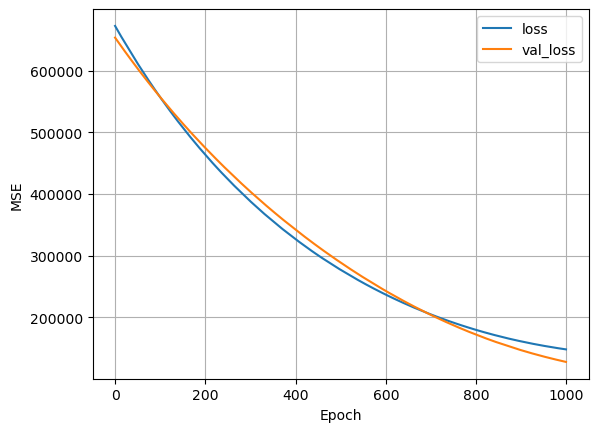

In [136]:
plot_loss(history) # Good if values are converging

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


<function matplotlib.pyplot.show(close=None, block=None)>

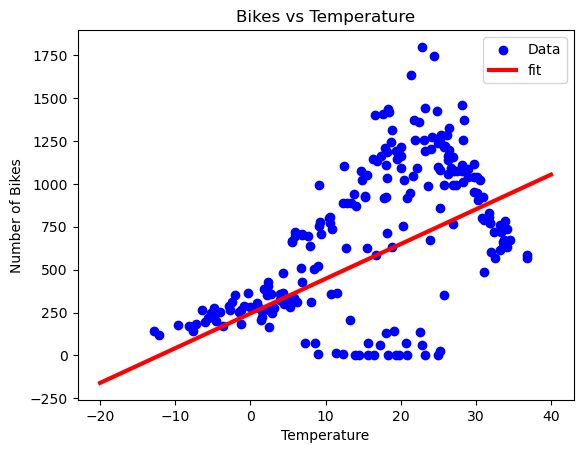

In [137]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x=tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1,1)), label="fit", color="red", linewidth=3) # Line width changes how thick value is
plt.legend()
plt.title("Bikes vs Temperature")
plt.ylabel("Number of Bikes")
plt.xlabel("Temperature")
plt.show

# This also gives off a linear regresison line

## Neural Net (Simple & Multiple)

In [138]:
temp_normalizer=tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

nn_model=tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1) # relu because you cannot have less than 0 bikes
])
# Even getting rid of the relu at the end Dense(1) indicates this is not the best model
# So you can add layers but play around with the models 

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss="mean_squared_error")

In [139]:
history=nn_model.fit(X_train_temp, y_train_temp, validation_data=(X_val_temp, y_val_temp),
                    verbose=0, epochs=100)

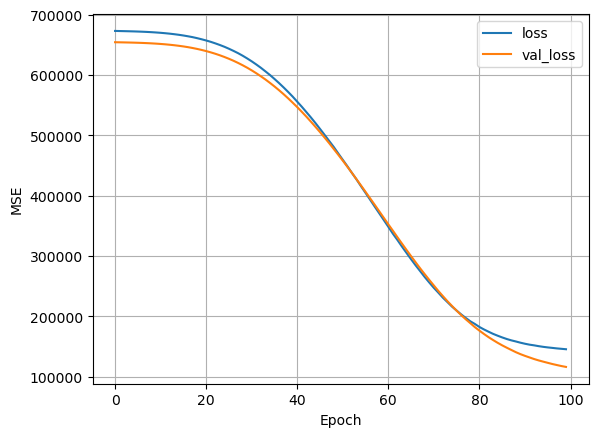

In [140]:
plot_loss(history)

# Decreasing means it is a good sign

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


<function matplotlib.pyplot.show(close=None, block=None)>

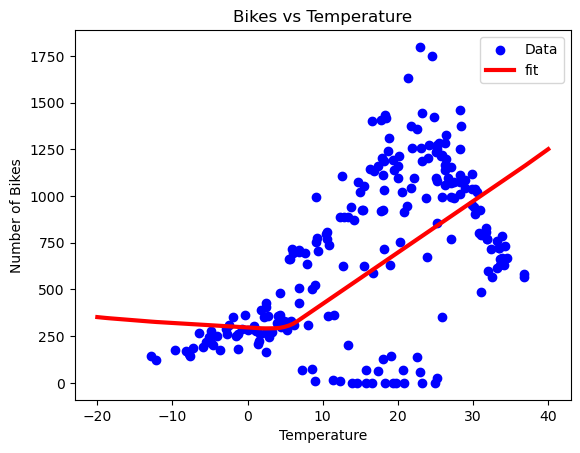

In [141]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x=tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1,1)), label="fit", color="red", linewidth=3) # Line width changes how thick value is
plt.legend()
plt.title("Bikes vs Temperature")
plt.ylabel("Number of Bikes")
plt.xlabel("Temperature")
plt.show

# A linear regressor would not be able to see this curve

In [142]:
# The above is no longer a linear predictor but we still get an estimate of the value
# Repeat above with multiple inputs!

# Had to add this part because my shape was wrong
# X_train_all=X_train_all.reshape((X_train_all.shape[0], 6, 1))
# X_val_all=X_val_all.reshape((X_val_all.shape[0], 6, 1))

all_normalizer=tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(X_train_all)

In [143]:
nn_model=tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss="mean_squared_error")

In [144]:
history=nn_model.fit(X_train_all, y_train_all, validation_data=(X_val_all, y_val_all),
                    verbose=0, epochs=100)

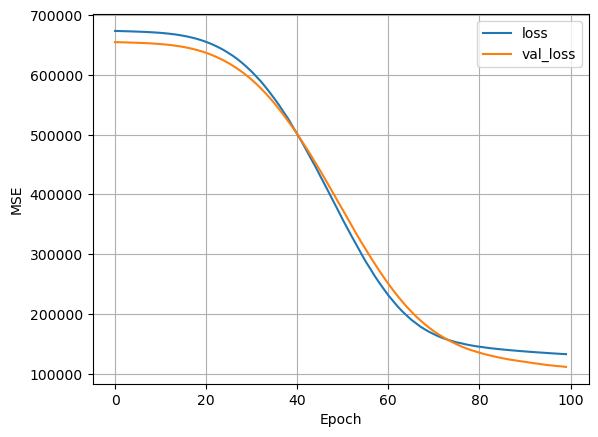

In [145]:
plot_loss(history)
# Odd shape but at least it is decreasing?

In [146]:
# Calculate the MSE for both linear reg and nn

# Predictions for multiple lr
y_pred_lr=all_reg.predict(X_test_all)
y_pred_nn=nn_model.predict(X_test_all)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [147]:
def MSE(y_pred, y_real):
    return (np.square(y_pred-y_real)).mean() # Equation for MSE

In [148]:
MSE(y_pred_lr, y_test_all)

101297.90177293237

In [149]:
MSE(y_pred_nn, y_test_all) # NN larger than LR 

138939.28047880542

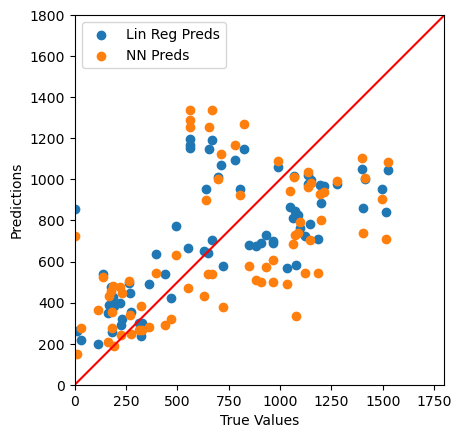

In [151]:
ax=plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Lin Reg Preds")
plt.scatter(y_test_all, y_pred_nn, label="NN Preds")
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims=[0,1800] # Approximately the max number of bikes (setting limits)
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_=plt.plot(lims, lims, c="red")

# NN tends to underestimate